In [42]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import itertools
from tqdm.auto import tqdm

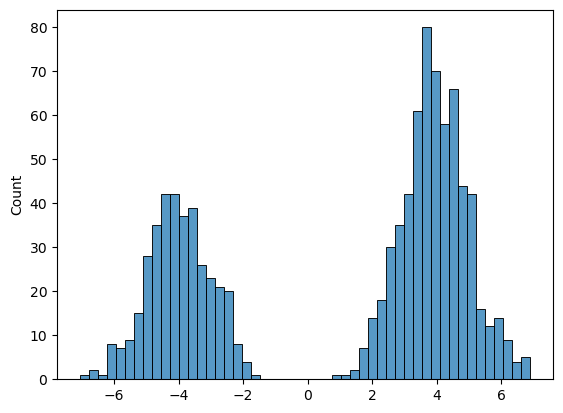

In [43]:
data_distribution = torch.distributions.mixture_same_family.MixtureSameFamily(
    torch.distributions.Categorical(torch.tensor([1, 2])),
    torch.distributions.Normal(torch.tensor([-4., 4.]), torch.tensor([1., 1.]))
)

dataset = data_distribution.sample(torch.Size([1000, 1]))
sns.histplot(dataset[:, 0], bins=50)
plt.show()


In [44]:
# we will keep these parameters fixed throughout
TIME_STEPS = 250
BETA = 0.02
ALPHA = 1 - BETA
ALPHA_BAR = [ALPHA ** i for i in range(TIME_STEPS+1)]

Pay attention - beta is constant, hence $x_{t+1}$ is sampled from $q_t = \N(\sqrt{1-\beta}x_t, \sqrt{\beta})$

In [45]:
def do_diffusion(data, steps=TIME_STEPS, beta=BETA):
    # perform diffusion following equation 2
    # returns a list of q(x(t)) and x(t)
    # starting from t=0 (i.e., the dataset)

    distributions, samples = [None], [data]
    xt = data # = data_distribution.sample(torch.Size([1000, 1]))
    for t in range(steps):
        q = torch.distributions.Normal(
            np.sqrt(1 - beta) * xt,
            np.sqrt(beta)
        ) # Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])) for each time step

        xt = q.sample() #torch.Size([1000, 1]) for each time step

        distributions.append(q)
        samples.append(xt)

    return distributions, samples 
    # distributions : list of length TIME_STEPS+1 of Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])) distributions
    # samples : list of length TIME_STEPS+1 of torch.Size([1000, 1]) samples from each distribution

In [46]:
_, samples = do_diffusion(dataset)

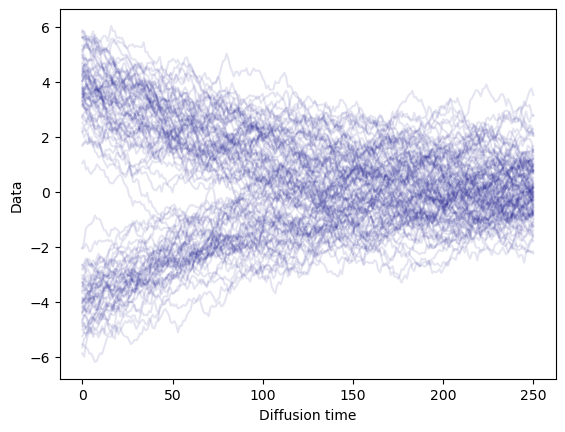

In [47]:
for t in torch.stack(samples)[:, :, 0].T[:100]:
    plt.plot(t, c='navy', alpha=0.1)
plt.xlabel('Diffusion time')
plt.ylabel('Data')
plt.show()

# Training
I use the loss in Equation 3 in the paper without any of the optimizations presented later, which only play a role for complex, real-world distributions.

In this case, diffusion models are trained by first corrupting the training examples, then trying to reconstruct the cleaner examples from the noisy examples at each step of the corruption process. The loss is an upper bound on the negative log likelihood:

$L := \mathbb{E}_q\left[
-\log p(x_T)
-\sum_{t=1}^T \log\frac{p_\theta(x_{t-1}|x_t)}{q(x_t|x_{t-1})} 
\right]$


Where the generative model, also called reverse process, has form:

$p_\theta(x_{t-1}|x_t):=\mathcal{N}(x_{t-1} ; \mu_\theta(x_t,t), \Sigma_\theta(x_t, t))$

Note that we are training two neural networks, $\mu_\theta$ and $\Sigma_\theta$, which take as input a noisy sample $x_t$ and the step $t$, and try to predict the parameters of the distribution of the sample $x_{t-1}$ to which noise was added. Intuitively, we are training these networks to maximize the predicted probability of observing the uncorrputed example $x_{t-1}$ based on $x_t$ , i.e., the term $p_\theta(x_{t-1}\vert x_t)$ in the loss, for each diffusion step. Remember that $x_t$ was generated earlier from $x_{t-1}$ by adding noise; the networks have to learn to undo the noise. The other terms in the loss involving $q(x_t\vert x_{t-1})$ are not necessary to learn a good generative model, since they are constant, but are useful as a “frame of reference” to make a “perfect” generative model achieve a loss of 0.

The loss is implemented in the function below. This function requires the entire diffusion trajectory for the training samples, as well as the two neural networks that define the inverse process:

In [48]:
def compute_loss_equation3(forward_distributions, forward_samples, mean_model, var_model):
    # here we compute the loss in equation 3
    # forward = q , reverse = p

    # loss for x(T)
    p = torch.distributions.Normal(
        torch.zeros(forward_samples[-1].shape),
        torch.ones(forward_samples[-1].shape)
    ) # Normal(loc: torch.Size([1000, 1]), scale: torch.Size([1000, 1])) standart normal distribution
    loss = -p.log_prob(forward_samples[-1]).mean() # estimate the E_q[-log(p(x(T)))] (3.1)

    for t in range(1, len(forward_samples)):
        xt = forward_samples[t]         # x(t) sample
        xprev = forward_samples[t - 1]  # x(t-1) sample
        q = forward_distributions[t]    # q( X(t) | x(t-1) ) distribution

        # normalize t between 0 and 1 + set the inputs of the mu and sigma networks
        xin = torch.cat( (xt, (t / len(forward_samples)) * torch.ones(xt.shape[0], 1)), 
            dim=1) # ( x(t),t ) the input as shown in equation 1

        mu = mean_model(xin) # estimate the mu( x(t),t ) as equation 1
        sigma = var_model(xin) # estimate the sigma( x(t),t ) as equation 1
        p = torch.distributions.Normal(mu, sigma) # estimate p( X(t-1) | x(t) ) as equation 1 for each sample

        # add a term to the loss
        loss -= torch.mean(p.log_prob(xprev)) # estimate the E_q[log(p(x(t-1) | x(t)))] (3.2)
        loss += torch.mean(q.log_prob(xt)) # estimate the E_q[log(q(x(t) | x(t-1)))] (3.3)

    return loss / len(forward_samples) # average on total time steps (otherwhise the loss is a fucntion of TIME_STEPS)


In [49]:
def compute_loss_equation10(forward_samples, mean_model):
    # here we compute the loss in equation 5 using equation 8 and 10 for L(t-1)
    # ALPHA = alpha(t) = 1 - beta(t) = 1 - BETA
    # ALPHA_BAR = alpha_bar(t) = multiply all alpha(s) for 1 <= s < t = ALPHA^t = (1 - BETA)^t 

    loss = 0 # initialize the loss

    for t in range(2, len(forward_samples)):
        xt = forward_samples[t]         # x(t) sample
        x0 = forward_samples[0]         # x(0) sample
        epsilon = torch.randn_like(x0)  # epsilon ~ N(0,1) for each sample

        # normalize t between 0 and 1 and add it as a new column to the input of the mu network
        xin = torch.cat(
            (xt, (t / len(forward_samples)) * torch.ones(xt.shape[0], 1)),
            dim=1
        ) # ( x(t),t ) the input as shown in equation 1
        mu_tetha = mean_model(xin) # mu_tilda(t) estimate by mu( x(t),t ) prediction (=mu_tetha) as equation 10
        
        xt_by_x0_epsilon = np.sqrt(ALPHA_BAR[t]) * x0 + np.sqrt(1-ALPHA_BAR[t]) * epsilon
        mu_tilda = 1/np.sqrt(ALPHA) * ( xt_by_x0_epsilon - ( BETA / np.sqrt( 1- ALPHA_BAR[t])) * epsilon ) # calculate mu_tilda(t) as equation 10
        
        loss += torch.mean(torch.square(mu_tetha - mu_tilda))

    sigma_squared = BETA # * torch.ones(xt.shape[0], 1) # set sigma as a constant (although it should be a function of t)
    loss = loss / 2 * sigma_squared # normalize the loss by the variance of the diffusion process (equation 10)

    return loss / (len(forward_samples)-2) # average on |1 < t <= T| (otherwhise the loss is a fucntion of TIME_STEPS)


In [50]:
def compute_loss_equation12(forward_samples, noise_model):
    # here we compute the loss in equation 5 using equation 12 reparmatrization to L(t-1)
    # ALPHA = alpha(t) = 1 - beta(t) = 1 - BETA
    # ALPHA_BAR = alpha_bar(t) = multiply all alpha(s) for 1 <= s < t = ALPHA^t = (1 - BETA)^t 

    loss = 0 # initialize the loss

    for t in range(2, len(forward_samples)):
        xt = forward_samples[t]         # x(t) sample
        x0 = forward_samples[0]         # x(0) sample
        epsilon = torch.randn_like(x0)  # epsilon ~ N(0,1) for each sample
        xt_by_x0_epsilon = np.sqrt(ALPHA_BAR[t]) * x0 + np.sqrt(1-ALPHA_BAR[t]) * epsilon

        # normalize t between 0 and 1 + set the inputs of the noise network
        xin = torch.cat( (xt_by_x0_epsilon , (t / len(forward_samples)) * torch.ones(xt.shape[0], 1)),
            dim=1 ) # ( x(t),t ) the input as shown in equation 1
            
        epsilon_tetha = noise_model(xin) # epsilon_tilda(t) estimate by epsilon( x(t),t ) prediction (=epsilon_tetha)
                
        # add a term to the loss
        loss += torch.mean(torch.square(epsilon_tetha - epsilon)) # estimate L(t-1)-C as equation 10

    sigma_squared = BETA # set sigma as a constant (although it should be a function of t)
    normalize_term = BETA ** 2 / (2 * sigma_squared * ALPHA * (1 - ALPHA_BAR[t])) # * torch.ones(xt.shape[0], 1) 
    loss = loss * normalize_term # normalize the loss by the variance of the diffusion process (equation 10)

    return loss / (len(forward_samples)-2) # average on |1 < t <= T| (otherwhise the loss is a fucntion of TIME_STEPS)


In [51]:
def compute_loss(equation, forward_distributions, forward_samples, mean_model, var_model, noise_model):
    if equation == 3:
        return compute_loss_equation3(forward_distributions, forward_samples, mean_model, var_model)
    elif equation == 10:
        return compute_loss_equation10(forward_samples, mean_model)
    elif equation == 12:
        return compute_loss_equation12(forward_samples, noise_model)
    else:
        raise ValueError('Invalid equation number')

Let us now define two very simple neural networks to predict the mean/variance/noise. These networks take two inputs: the noisy sample $x_t$ and the normalized time-step t. The time-step is added as an additional column feature, and, since the input is also one-dimensional, the total input size is two.

In [52]:
mean_model = torch.nn.Sequential(
    torch.nn.Linear(2, 4), torch.nn.ReLU(),
    torch.nn.Linear(4, 1)
)
var_model = torch.nn.Sequential(
    torch.nn.Linear(2, 4), torch.nn.ReLU(),
    torch.nn.Linear(4, 1), torch.nn.Softplus()
)
noise_model = torch.nn.Sequential(
    torch.nn.Linear(2, 4), torch.nn.ReLU(),
    torch.nn.Linear(4, 1)
)

In [53]:
optim = torch.optim.AdamW(
    itertools.chain(mean_model.parameters(), var_model.parameters(), noise_model.parameters()),
    lr=1e-2, weight_decay=1e-6,
)

In [54]:
loss_history = []
bar = tqdm(range(1))
for e in bar:
    forward_distributions, forward_samples = do_diffusion(dataset)

    optim.zero_grad()
    loss = compute_loss(
        3,forward_distributions, forward_samples, mean_model, var_model, noise_model
    )
    loss.backward()
    optim.step()

    bar.set_description(f'Loss: {loss.item():.4f}')
    loss_history.append(loss.item())


  0%|          | 0/1 [00:00<?, ?it/s]

In [55]:
import torch

def save_model(model, filepath):
    """
    Save the PyTorch model to a file.
    
    Args:
        model (torch.nn.Module): The PyTorch model to save.
        filepath (str): The path to save the model file.
    """
    torch.save(model.state_dict(), filepath)
    print("Model saved successfully.")

def load_model(model_class, filepath):
    """
    Load a PyTorch model from a file.
    
    Args:
        model_class (torch.nn.Module): The class of the PyTorch model to load.
        filepath (str): The path to the saved model file.
        
    Returns:
        model (torch.nn.Module): The loaded PyTorch model.
    """
    model_type = filepath.split("/")[-1].split("_")[0]
    if model_type == "mean":
        model = torch.nn.Sequential(
            torch.nn.Linear(2, 4), torch.nn.ReLU(),
            torch.nn.Linear(4, 1)
        )
    elif model_type == "var":
        model = torch.nn.Sequential(
            torch.nn.Linear(2, 4), torch.nn.ReLU(),
            torch.nn.Linear(4, 1), torch.nn.Softplus()
        )
    elif model_type == "noise":
        model = torch.nn.Sequential(
            torch.nn.Linear(2, 4), torch.nn.ReLU(),
            torch.nn.Linear(4, 1)
        )
    else:
        raise ValueError("Invalid model type.")            

    model.load_state_dict(torch.load(filepath), strict=False)
    model.eval()
    print("Model loaded successfully.")
    return model

#save_model(mean_model, "models/mean_model.pth")
#save_model(var_model, "models/var_model.pth")
#save_model(noise_model, "models/noise_model.pth")


mean_model = load_model(torch.nn.Sequential, "models/mean_model.pth")
var_model = load_model(torch.nn.Sequential, "models/var_model.pth")
noise_model = load_model(torch.nn.Sequential, "models/noise_model.pth")

Model loaded successfully.
Model loaded successfully.
Model loaded successfully.


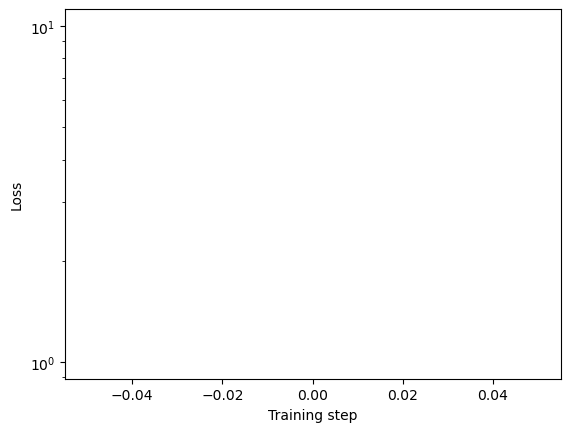

In [56]:
plt.plot(loss_history)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training step')
plt.show()

Sample generation
Finally, with the trained neural networks, we can generate new samples from the data distribution.

This process is very similar to the earlier diffusion process, except that here we start from a Normally-distributed $x_T$ and use the predicted mean and variance to gradually “remove” noise:



In [57]:
def sample_reverse_equation3(mean_model, var_model, count, steps=TIME_STEPS):
    p = torch.distributions.Normal(torch.zeros(count, 1), torch.ones(count, 1))
    xt = p.sample()
    sample_history = [xt]
    for t in range(steps, 0, -1):
        xin = torch.cat((xt, t * torch.ones(xt.shape) / steps), dim=1)
        p = torch.distributions.Normal(
            mean_model(xin), var_model(xin)
        )
        xt = p.sample()
        sample_history.append(xt)
    return sample_history

In [58]:
def sample_reverse_equation12(noise_model, count, steps=TIME_STEPS):
    p = torch.distributions.Normal(torch.zeros(count, 1), torch.ones(count, 1))
    xt = p.sample()
    sample_history = [xt]
    for t in range(steps, 0, -1):
        
        z = torch.randn_like(xt)
        if t == 0:
            z=0

        xin = torch.cat(
            (xt , (t / len(forward_samples)) * torch.ones(xt.shape[0], 1)), dim=1 ) # ( x(t),t ) the input as shown in equation 1

        epsilon_tetha = noise_model(xin) # mu_tilda(t) estimate by mu( x(t),t ) prediction (=mu_tetha) as equation 10
                
        xprev = 1/np.sqrt(ALPHA) * ( xt - ( BETA / np.sqrt( 1- ALPHA_BAR[t])) * epsilon_tetha )

        sample_history.append(xt)
        xt = xprev
        
    return sample_history

In [59]:
def sample_reverse(equation, mean_model, var_model, noise_model, count, steps=1000):
    if equation == 3:
        return sample_reverse_equation3(mean_model, var_model, count )
    elif equation == 10:
        return sample_reverse_equation10(mean_model, count)
    elif equation == 12:
        return sample_reverse_equation12(noise_model, count)
    else:
        raise ValueError('Invalid equation number')

In [74]:
samps = torch.stack(sample_reverse(3, mean_model, var_model, noise_model, 10000))

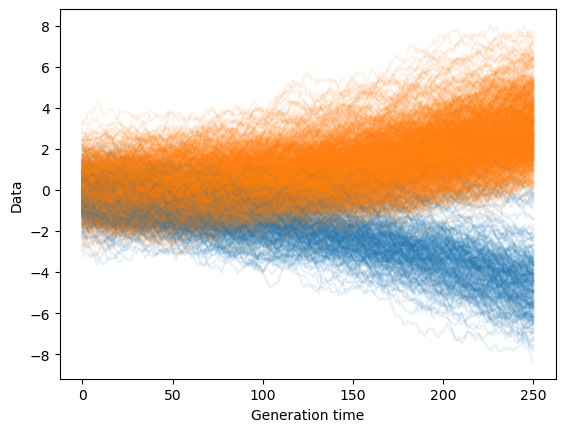

In [75]:
for t in samps[:,:,0].T[:1000]:
    plt.plot(t.detach().numpy(), c='C%d' % int(t[-1] > 0), alpha=0.1)
plt.xlabel('Generation time')
plt.ylabel('Data')
plt.show()

/Users/avishagnevo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1006: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


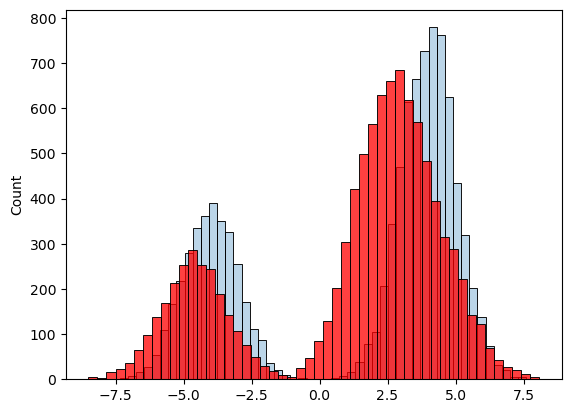

In [81]:
original_samples = data_distribution.sample(torch.Size([10000, 1]))  # from your target distribution
sns.histplot(original_samples, bins=50, alpha=0.3, color='blue', legend=False)
sns.histplot(samps[-1, :, 0].detach().numpy() , bins=50, color='red')
plt.show()

In [96]:
original_samples = data_distribution.sample(torch.Size([10000, 1]))  # from your target distribution
generated_samples_3 =  torch.stack(sample_reverse(3, mean_model, var_model, noise_model, 10000))[-1, :, 0] # from your trained model
generated_samples_12 =  torch.stack(sample_reverse(12, mean_model, var_model, noise_model, 10000))[-1, :, 0] # from your trained model

In [102]:
import numpy as np
from scipy.linalg import sqrtm

for generated_samples in [generated_samples_3, generated_samples_12]:
    # Calculate means
    mu_original = torch.mean(original_samples, axis=0).detach().numpy()[0]
    mu_generated = np.mean(generated_samples.detach().numpy(), axis=0)

    # Calculate covariances
    sigma_original = np.cov(original_samples.T)
    sigma_generated = np.cov(generated_samples.detach().numpy().T)

    # Compute the difference in means
    mean_diff = mu_original - mu_generated
    mean_norm = np.sum(mean_diff ** 2)

    # Compute the sqrt of the product of covariances
    cov_sqrt = (sigma_original * sigma_generated)**0.5

    # Handle numerical errors for complex numbers
    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real

    # Compute the trace term for 1D matrix
    cov_trace = sigma_original + sigma_generated - 2 * cov_sqrt

    # Compute the FID
    fid = mean_norm + cov_trace
    print("FID:", fid)


FID: 0.18865391178810498
FID: 0.5726948818463029
